#### Notes
- Will need to incorporate weight at some point in order to compete with strava
- Need to handle different time frequency data. Ex, time with 3 second freqeuency will be 15 second total interval.
- Need to handle timezones
- Need to get wind at different elevations


Input features:
Concatenation of 5 time-series datapoints, each having:
- Time delta from previous point (seconds)
- Latitude delta from previous point (decimal degrees)
- Longitude delta from previous point (decimal degrees)
- Elevation delta from previous point (meters)
- Wind speed (m/s)
- Wind direction (degrees)

Justifications
- Time delta: Need to represent time, but want the model to be robust to time of day, date in time.
- Latitude delta: Need to represent distance, but want the model to be robust to location
- Longitude delta: Need to represent distance, but want the model to be robust to location
- Elevation delta: Need to represent elevation, but want the model to be robust to location

Output features:
- 5 second power in watts (target)

Cross/validate
- Lat/lon delta only
- Instantaneous speed only
- Instantaneous speed + lat/lon delta

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import sys
sys.path.append('../src')

from fit.util import fit_to_df
from wind.util import add_wind_data
from wind.providers import OpenMeteoProvider
from data.datasets import STPowerDataset

In [2]:
dfs = []
for fit_file in os.listdir('../data/fit'):
    if not fit_file.endswith('.fit'):
        continue
    df = fit_to_df('../data/fit/' + fit_file)
    df['name'] = fit_file
    dfs.append(df)
df = pd.concat(dfs)
df = df[df['power'].notnull()]

In [11]:
df = fit_to_df('../data/fit/Afternoon_Ride (1).fit')

In [12]:
df = df.copy() # Avoid SettingWithCopyWarning
df['position_lat'] = df['position_lat'] / 1e7
df['position_long'] = df['position_long'] / 1e7

In [13]:
wind = OpenMeteoProvider()
df_with_wind = add_wind_data(df, 'timestamp', 'position_lat', 'position_long', wind)
df_with_wind.to_csv('../data/dataframes/fit_with_wind.csv', index=False)

In [14]:
df_with_wind = pd.read_csv('../data/dataframes/fit_with_wind.csv')

In [15]:
batch_size = 32
window_size = 3 
learning_rate = 5e-4
epochs = 50 

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
from torch.utils.data import DataLoader
dataset = STPowerDataset(df_with_wind, window_size=window_size, device=device)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataloader)

78

In [18]:
import torch.nn as nn
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
       super(SimpleRNN, self).__init__() 
       self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first = True)
       self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.fc(output[:, -1, :])
        return output

In [19]:
model = SimpleRNN(input_size = 6, hidden_size = 32)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.to(device)
criterion.to(device)

MSELoss()

In [ ]:
min_loss = float('inf')
train_losses = []
for epoch in range(epochs):
    batch_loss = 0
    for i, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(x)
        print(output.shape, y.shape)
        loss = criterion(output, y)
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    if batch_loss < min_loss:
        min_loss = batch_loss
        torch.save(model.state_dict(), '../training_checkpoints/simplernn_v1p0.pt')
    train_losses.append(batch_loss / len(dataloader))
    print(f'Epoch: {epoch}, Loss: {loss.item()}')

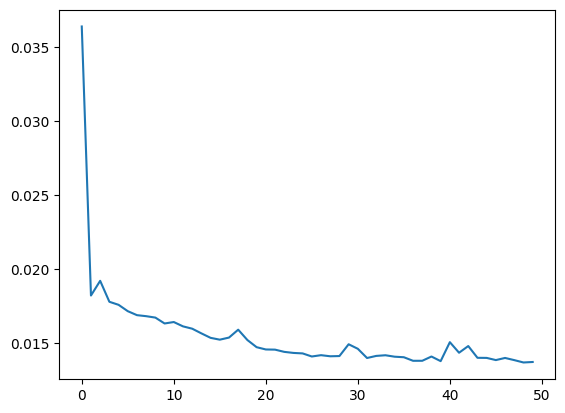

In [33]:
plt.plot(train_losses)

In [8]:
best_model = SimpleRNN(6, 32)
best_model.load_state_dict(torch.load('../training_checkpoints/rnn.pt'))

<All keys matched successfully>

Mean Power: 206.0171661376953
Mean Power Pred: 207.90591430664062


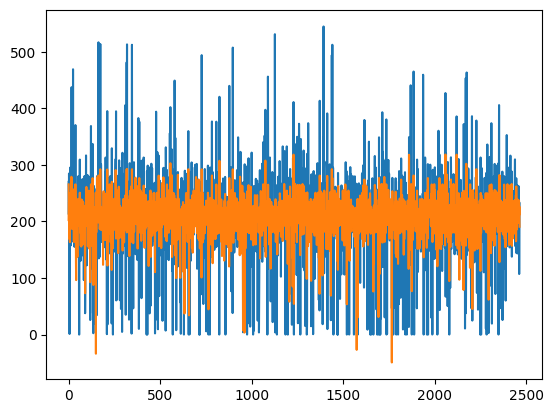

In [34]:
model.eval()
powers = []
power_preds = []
with torch.no_grad():
    for i, (x, y) in enumerate(dataloader):
        pred_power = model(x)
        pred_power = dataset.output_scaler.inverse_transform(pred_power.cpu().numpy())
        power = dataset.output_scaler.inverse_transform(y.cpu().numpy())
        powers.append(power)
        power_preds.append(pred_power)

# Debatch
powers = np.concatenate(powers)
power_preds = np.concatenate(power_preds)
print(f'Mean Power: {powers.mean()}')
print(f'Mean Power Pred: {power_preds.mean()}')


plt.plot(powers)
plt.plot(power_preds)